# 3. Working with data

## 3.0 Preamble

At the top of almost every piece of scientific computing work, we'll import these standard modules.

In [2]:
# Import modules, and give them short aliases so we can write e.g. np.foo rather than numpy.foo
import math, random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import scipy
import scipy.optimize
import pandas
from collections import OrderedDict
# The next line is a piece of magic, to let plots appear in our Jupyter notebooks
%matplotlib inline 

We'll also import the `ucamcl` module. In addition to the autograder, it contains some convenient data-handling routines.

In [3]:
#!pip3 install ucamcl -q
import ucamcl
from ucamcl.fds import summary, cut
#GRADER = ucamcl.autograder(https://markmy.solutions/', course='scicomp', section='notes2')

# 3.1 What data looks like

Scientific computing is all about the data. We almost always work with data in the form of a spreadsheet-like table, often referred to as a _data frame_. 
Here is a example: a sample of rows from a classic dataset (the [Iris dataset](https://en.wikipedia.org/wiki/Iris_flower_data_set), introduced by [Ronald Fisher](https://en.wikipedia.org/wiki/Ronald_Fisher) in 1936; Fisher was described as a "genius who almost single-handedly created the foundations for modern statistical science").

| Sepal.Length | Sepal.Width | Petal.Length | Petal.Width | Species |
|----------------------------------------------------------------|
| 7.7          |        3.8  |         6.7  |        2.2  |  virginica
| 5.3          |        3.7  |         1.5  |        0.2  |     setosa
| 5.8          |        2.7  |         5.1  |        1.9  |  virginica
| 5.5          |        2.4  |         3.7  |        1.0  | versicolor
| 6.7          |        3.0  |         5.2  |        2.3  |  virginica

A data frame is a collection of named columns. Each column has the same length, and all entries in a column have the same type, though different columns may have different types. It is basically the same as a table in a relational database (except that you should think of scientific data tables as logs of observations, which means that the UPDATE and DELETE database operations are irrelevant, as are questions about database consistency).

In Python, we have a choice about how to store data frames. A simple choice, which we'll use in this notebook, is to store them as dictionaries of `numpy` vectors, e.g.

In [ ]:
iris = {'Sepal.Length': np.array([7.7, 5.3, 5.8, 5.5, 6.7]),
        'Sepal.Width': np.array([3.8, 3.7, 2.7, 2.4, 3.0]),
        'Petal.Length': np.array([6.7, 1.5, 5.1, 3.7, 5.2]),
        'Petal.Width': np.array([2.2, 0.2, 1.9, 1.0, 2.3]),
        'Species': np.array(['virginica', 'setosa', 'virginica', 'versicolor', 'verginica'])}

For example, to extract the rows with `virginica` records,

In [ ]:
i = iris['Species'] == 'virginica'
iris_virginica = {k:v[i] for k,v in iris.items()}

### Special classes for data frames

In IA _Object Oriented Programming_, you learnt about modularity and encapsulation. Why not design a class to hold data frames? It could provide convenient methods to extract rows etc. It could also incorporate checks e.g. to make sure we don't accidentally set some columns to have different lengths, or to help spot typos like the misspelled _verginica_ above. There are indeed such classes, such as [`pandas.DataFrame`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.html) and `numpy`'s [structured arrays](https://docs.scipy.org/doc/numpy/user/basics.rec.html#module-numpy.doc.structured_arrays). (The difference between structured arrays and regular arrays is that in a structured array each column can have a different type.)

You may also have gathered from _Object Oriented Programming_ that good classes are hard to design. In my opinion, neither `pandas.DataFrame` nor structured arrays are mature designs, and by the time you graduate there will probably be something better. That's why, for this course, we will mostly use plain Python dictionaries. There are however three caveats.

* Data import and export has lots of fiddly corner cases. Even printing a data frame takes a surprisingly large amount of code to do well. For these purposes we'll use `pandas.DataFrame`. This class also makes it convenient to pick out rows using the standard Python slice notation, e.g. `df[:5]` to get the first five rows.

* For fast numerical computation and concise code `numpy` is best, as we saw in &sect;2. A number of useful `numpy` routines work on structured arrays. 

* It's nice to keep columns in order, for nice presentation. Python has a special class `collections.OrderedDict` which is like a dictionary except it preserves the order of the keys. When we care about column order, we'll use this rather than plain dictionaries.

Here's another take on the iris dataset:

In [ ]:
# Store data frames as OrderedDict, so we can specify the order of the columns
iris = OrderedDict([('Sepal.Length', np.array([7.7, 5.3, 5.8, 5.5, 6.7])),
                    ('Sepal.Width', np.array([3.8, 3.7, 2.7, 2.4, 3.0])),
                    ('Petal.Length', np.array([6.7, 1.5, 5.1, 3.7, 5.2])),
                    ('Petal.Width', np.array([2.2, 0.2, 1.9, 1.0, 2.3])),
                    ('Species', np.array(['virginica', 'setosa', 'virginica', 'versicolor', 'verginica']))])

# Convert it to a pandas.DataFrame for nice printing
pandas.DataFrame(iris)

## 3.1 Importing and exporting data

When your data is a very simple comma-separated value (CSV) file then it's very easy to import. A CSV file looks like this:
```
"Sepal.Length","Sepal.Width","Petal.Length","Petal.Width","Species"
5.1,3.5,1.4,0.2,"setosa"
4.9,3,1.4,0.2,"setosa"
4.7,3.2,1.3,0.2,"setosa"
4.6,3.1,1.5,0.2,"setosa"
5,3.6,1.4,0.2,"setosa"
```
i.e. a header line, then one line per row of the data frame, with values separated by commas.
Here is code to import a simple CSV file:

In [ ]:
iris = pandas.read_csv('data/iris.csv')          # this returns a pandas.DataFrame
iris = {col: iris[col].values for col in iris}   # (optional) convert it to dict of vectors

You can also use `pandas.read_csv` to import a CSV stored on a web server. The data was prepared from the Environment Agency's [web API](http://environment.data.gov.uk/flood-monitoring/doc/reference), put into a database, then summarized from the database and copied into [Azure Blob Storage](https://azure.microsoft.com/en-gb/services/storage/blobs/). See 
[Appendix A](A.%20Data%20import%20and%20cleanup.ipynb) for details.

In [4]:
# standard library for web requests
import urllib.request
my_url = "https://teachingfiles.blob.core.windows.net/scicomp/flood.csv"

# The 'with' syntax means: f=urlopen(my_url), do stuff, then call f.close().
# This syntax is useful for any resource that needs to be released/closed after use.
with urllib.request.urlopen(my_url) as f:
    flood = pandas.read_csv(f)
    flood = OrderedDict((k, flood[k].values) for k in flood)
    
# Show the first 4 rows
pandas.DataFrame(flood)[:4]

,label,id,lat,lng,town,river,measure_id,qualifier,parameter,period,low,high,valuetype,t,value
0,Cambridge Jesus Lock,E60501,52.212835,0.120872,Cambridge,River Cam,1702,Stage,Water Level,900.0,0.637,0.74,instantaneous,2017-08-07T07:00:00Z,0.680
1,Cambridge Jesus Lock,E60501,52.212835,0.120872,Cambridge,River Cam,1702,Stage,Water Level,900.0,0.637,0.74,instantaneous,2017-08-07T00:45:00Z,0.682
2,Cambridge Jesus Lock,E60501,52.212835,0.120872,Cambridge,River Cam,1702,Stage,Water Level,900.0,0.637,0.74,instantaneous,2017-08-07T04:00:00Z,0.681
3,Cambridge Jesus Lock,E60501,52.212835,0.120872,Cambridge,River Cam,1702,Stage,Water Level,900.0,0.637,0.74,instantaneous,2017-08-07T01:00:00Z,0.681


If your file is nearly a CSV but has some quirks such as comments or a missing header row, experiment with the options in [`pandas.read_csv`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) or [`pandas.read_table`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_table.html). For extreme quirks you may need to use the raw Python [`csv.reader`](https://docs.python.org/3/library/csv.html#csv.reader).

To write a CSV file, it's easiest to use `pandas.DataFrame.to_csv()`. 
If you're running this notebook with Azure Notebooks, use the Data | Download menu to download the CSV.

In [ ]:
# Convert a dictionary of vectors into pandas.DataFrame
x = pandas.DataFrame(flood)[:100]
# Write it to a file. Pandas likes to add a column with row numbers, which index=False suppresses.
x.to_csv('temp.csv', index=False)

In my experience, around 75% of the time you spend working with data will be fighting to import it and clean it up. For the most part this is just general-purpose programming, but there are a few library routines that will save you from reinventing the wheel. See
[&sect;A. Data import and cleanup](A.%20Data%20import%20and%20cleanup.ipynb) for a collection of recipes for

* [reading from a URL](A.%20Data%20import%20and%20cleanup.ipynb#readurl)
* [parsing a log file using regular expressions](A.%20Data%20import%20and%20cleanup.ipynb#regexp)
* [reading JSON from a web service](A.%20Data%20import%20and%20cleanup.ipynb#json)
* [scraping a website with XPath](A.%20Data%20import%20and%20cleanup.ipynb#xpath)
* [reading from an SQL database](A.%20Data%20import%20and%20cleanup.ipynb#sql)

## 3.2 Numerical data
After importing the `flood` data frame, and looking at a few sample rows, we'll inspect it more thoroughly. Let's look at the `value` column. The sample rows suggest that it's numerical, and we can verify this by checking its type:

In [4]:
flood['value'].dtype

dtype('float64')

A quick way to get a sense of the distribution is to find its percentiles, e.g. the 25 %ile is what you get if you sort the numbers from lowest to highest and look 25% of the way along. Numpy has a function [`np.percentile`](https://docs.scipy.org/doc/numpy/reference/generated/numpy.percentile.html) for this, and also [`np.nanpercentile`](https://docs.scipy.org/doc/numpy/reference/generated/numpy.nanpercentile.html) which removes NaN ("not a number") items first.

In [5]:
np.nanpercentile(flood['value'], q=[0, 25, 50, 75, 100])

array([-1.3  ,  0.095,  0.174,  0.668,  0.915])

For convenience, `ucamcl.fds.summary` computes these percentiles, and also shows the mean (computed by [`np.nanmean`](https://docs.scipy.org/doc/numpy/reference/generated/numpy.nanmean.html) to remove NaNs first) and the count of how many NaNs there are.

In [8]:
summary(flood['value'])

SummaryNumeric(min=-1.3, q25=0.095000000000000001, med=0.17399999999999999, mean=0.31475308575432548, q75=0.66799999999999993, max=0.91500000000000004, nan=2)

Or we can show the distribution of values with a histogram.

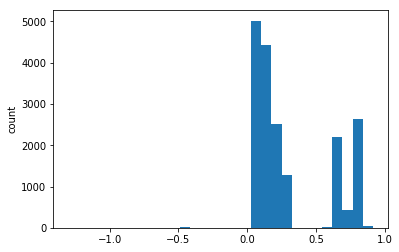

In [9]:
x = flood['value']
x = x[~np.isnan(x)]    # plt.hist needs us to remove NaN values first
plt.hist(x, bins=30)
plt.ylabel('count')
plt.show()

## 3.3 Categorical data
Let's look at another column, `flood['town']`, which is not numerical. Let's see the most frequent values and their counts.

In [9]:
vs,ns = np.unique(flood['town'], return_counts=True)  # the unique items, and the count of each
i = np.argsort(-ns)[:5]                                # the indexes of up to 5 items with the highest counts
np.vstack([vs[i], ns[i]]).T                            # show one column for these items, and one for the counts

array([['Cambridge', 7963],
       ['Cam', 2665],
       ['Weston Bampfylde', 2657],
       ['Milton', 2653],
       ['Great Shelford', 2617]], dtype=object)

For convenience, `ucamcl.fds.summary` does this tabulation, and also shows how many further items there are if any.

In [10]:
summary(flood['town'])

[('Cambridge', 7963),
 ('Cam', 2665),
 ('Weston Bampfylde', 2657),
 ('Milton', 2653),
 ('Great Shelford', 2617)]

Or we can show the distribution of values with a histogram. We have to do the counting ourselves then draw bars with 
[`matplotlib.pyplot.bar`](https://matplotlib.org/api/pyplot_api.html#matplotlib.pyplot.bar).

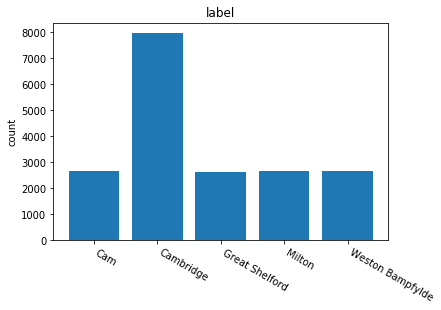

In [11]:
vs,ns = np.unique(flood['town'], return_counts=True)
xs = np.arange(len(vs))                               # pick x-coordinates 0, 1, ..., len(vs)-1
plt.bar(xs, ns, align='center')                       # use width=... to set the bar width
plt.xticks(xs, vs, rotation=-30, ha='left')           # label the x-coordinates of the bars
plt.ylabel('count')
plt.title('label')
plt.show()

## 3.4 Splitting numbers into categories<a name="cut"></a>
Sometimes it's useful to simplify a numerical column by splitting it into categories, e.g. bottom third, middle third, top third. We can find the breakpoints with [`np.percentile`](https://docs.scipy.org/doc/numpy-dev/reference/generated/numpy.percentile.html), and find the categories with [`np.digitize`](https://docs.scipy.org/doc/numpy/reference/generated/numpy.digitize.html).

In [7]:
# Each measurement station has its own 'low' and 'high' ranges.
# Let's normalize the values, so that low=0 and high=1, and categorize these normalized values.
x = (flood['value'] - flood['low']) / (flood['high'] - flood['low'])

# np.digitize returns integers saying which bin each number falls in.
# We'll cast it to be a string, so that summary() displays it as categorical.
y = np.digitize(x, bins=np.nanpercentile(x, [100/3, 200/3]))
summary(y.astype(str))

[('1', 6244), ('2', 6192), ('0', 6119)]

Bothersomely, `np.digitize` lumps NaNs into the highest bin, which is misleading. For convenience, `ucamcl.fds.cut` takes care of NaNs, and it also gives more helpful labels to the categories.

In [5]:
summary(cut(x, breaks=2))

[('[0.052, 0.368)', 6244),
 ('[0.368, inf)', 6190),
 ('(-inf, 0.052)', 6119),
 ('nan', 2)]

<div style="background-color:wheat"><strong>Excercise.</strong>
The <code style="background-color:wheat">cut</code> function uses 
<code style="background-color:wheat">np.nanpercentile</code> to split the data into equal percentile ranges.
So why are the counts not equal?
</div>

## 3.4 Geographic data
This data frame has columns `lat` and `lng` which are likely map coordinates. Matplotlib does have routines for map plots (see the [example gallery](https://matplotlib.org/basemap/users/examples.html)), and there are also many contributed libraries of varying quality. Here is a quick and dirty plot on top of Google Maps.
![map plot](fig/gmplot.png)

In [13]:
# Count the number of flood readings at each (lat,lng) pair
vs, ns = np.unique(np.vstack([flood['lat'],flood['lng']]).T, return_counts=True, axis=0)

In [14]:
!pip3 install gmplot -q                             # install a library for Google Map plots
import gmplot
import tempfile, webbrowser

gmap = gmplot.GoogleMapPlotter(52.212, 0.1208, 12)  # define the center of the view, and the zoom level
for x,y,r in zip(vs[:,0],vs[:,1],ns):
    gmap.circle(x, y, r/10)                         # add circles at every (lat,lng) pair
                                                    # (we need bigger circles though, for a zoomed-out map)

f = tempfile.NamedTemporaryFile(suffix='.html')     # gmap renders the map to an html file
gmap.draw(f.name)
webbrowser.open('file://' + f.name);                # and we open the file in a browser

## 3.5 Grouped statistics<a name="groupby"></a>
So far we've only looked at one column at a time. Let's now turn to the relationship between columns (also known as [multivariate analysis](https://en.wikipedia.org/wiki/Multivariate_statistics), as opposed to the univariate analysis we've seen so far). For example, what's the typical range of water levels (`value`) at each measurement station (`label`)? To find this, we need to group the rows of the dataframe, one row for each value of `label`, and for each group we'll compute some summary statistics.

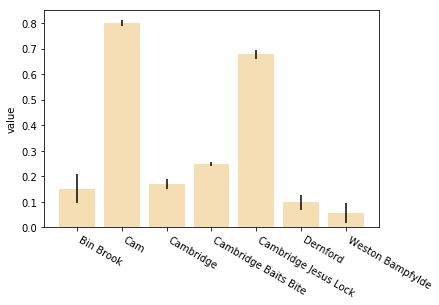

In [18]:
res = {'label':[], 'n':[], 'mean':[], 'sd':[]}
for lbl in np.unique(flood['label']):
    i = flood['label'] == lbl
    res['label'].append(lbl)
    res['n'].append(np.count_nonzero(i))
    res['mean'].append(np.nanmean(flood['value'][i]))
    res['sd'].append(np.nanstd(flood['value'][i]))

# Bar plot, with error bars
xs = np.arange(len(res['label']))
plt.bar(xs, res['mean'], align='center', facecolor='wheat')
plt.errorbar(xs, res['mean'], yerr=res['sd'], linestyle='None', ecolor='k')
plt.xticks(xs, res['label'], rotation=-30, ha='left')
plt.ylabel('value')
plt.show()

<div style="background-color:wheat"><strong>Exercise.</strong>
Implement the above code more efficiently, using vectorized operations rather than a <code style="background-color:wheat">for</code> loop. Hint: <a href="https://stackoverflow.com/a/23271510">stackoverflow.com/a/23271510</a>.
What is the complexity of the above code in terms of <em>n</em>, the length of the vector, and <em>k</em>, the number of unique levels?
</div>

## 3.6 Grouped plots (and timestamps)
The next plot shows how three columns relate to each other: the water levels (`value`) as a function of time (`t`), at each of the different measurement stations (`label`).

The first step is to fix up the time column, so that `matplotlib` knows it's a timestamp and not just a string, so that it will display nicely. The [documentation](http://environment.data.gov.uk/flood-monitoring/doc/reference) says that timestamps are in UTC. As [xkcd](https://www.xkcd.com/1883/) observes, timestamps are a nuisance because of timezones &mdash; and also because of unequal months and leap years and so on, which make it hard work to get axes right in plots.

<a href="https://www.xkcd.com/1883/"><img src="https://imgs.xkcd.com/comics/supervillain_plan.png" style="height:30em" alt="supervillain timezone woes"></a>

In [23]:
import datetime, pytz
x = flood['t']
# Parse the timestamp strings (see https://docs.python.org/3/library/datetime.html#datetime.datetime.strptime)
x = [datetime.datetime.strptime(tstr, '%Y-%m-%dT%H:%M:%SZ') for tstr in x]
# Mark each timestamp as a UTC timestamp
x = [t.replace(tzinfo=pytz.utc) for t in x]
# Convert it to a local timestamp (which in this case is British Summer Time, one hour off UTC)
local_tz = pytz.timezone('Europe/London')
x = [t.astimezone(local_tz) for t in x]
# Store it in the data frame as a numpy vector, so we can use numpy indexing on it
flood['t2'] = np.array(x)

The core of this plotting code is a loop over unique values of `flood['label']`, just like we did in 
[&sect;3.5 Grouped Statistics](#groupby).

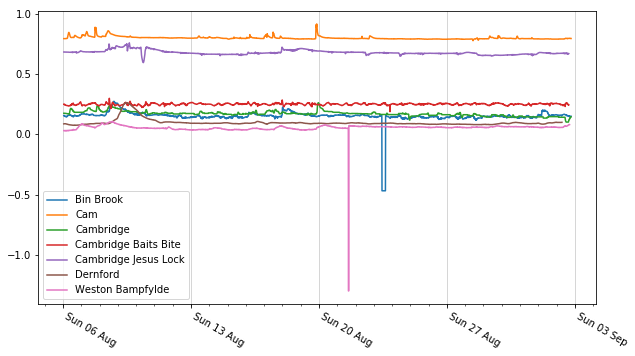

In [25]:
labels = np.unique(flood['label'])

with matplotlib.rc_context({'figure.figsize': [10,6]}):
    
    fig,ax = plt.subplots()
    for lbl in labels:
        i = flood['label'] == lbl
        t,v = flood['t2'][i], flood['value'][i]
        j = np.argsort(t)
        ax.plot(t[j], v[j], linestyle='-', label=lbl)

    ax.legend()
    ax.xaxis.set_major_locator(matplotlib.dates.WeekdayLocator(byweekday=matplotlib.dates.MO, tz=local_tz))
    ax.xaxis.set_minor_locator(matplotlib.dates.DayLocator(tz=local_tz))
    ax.xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%a %d %b'))
    ax.grid(True, axis='x', color='0.8')
    fig.autofmt_xdate(bottom=0.2, rotation=-30, ha='left')

 There is plenty of plot-tweaking around the core loop.

* The [`with matplotlib.rc_context`](https://matplotlib.org/api/matplotlib_configuration_api.html#matplotlib.rc_context) syntax sets the plot size to be 10x6 nominal inches, but only for the current plot. See [customizing matplotlib](https://matplotlib.org/users/customizing.html) for more information about available parameters, and for instructions on setting them globally.

* [`plt.subplots()`](https://matplotlib.org/api/pyplot_api.html?highlight=matplotlib%20pyplot%20subplots#matplotlib.pyplot.subplots) returns a pair `(fig,ax)` where `fig` lets you control the entire plot and `ax` is what you actually use for plotting. So far we have used e.g. `plt.plot(x,y)` to plot points. This is just an alias for `ax.plot(x,y)`, and `ax` has [more methods](https://matplotlib.org/api/axes_api.html) to customize the plot.

* We have to sort the points by time with `j = np.argsort(t)`, because if the times were out of order then the line would go back and forth across the plot.

* `ax.plot(x,y,label)` picks a different colour each time, and remembers the association between colours and labels, so that `ax.legend()` can draw the right thing.

* The code for picking good axis labels comes from a [matplotlib date demo](https://matplotlib.org/examples/api/date_demo.html).

## 3.7 Faceted plots
[According to the plotting guru Edward Tufte](https://en.wikipedia.org/wiki/Small_multiple),
<blockquote>
At the heart of quantitative reasoning is a single question: Compared to what? Small multiple designs, multivariate and data bountiful, answer directly by visually enforcing comparisons of changes, of the differences among objects, of the scope of alternatives. For a wide range of problems in data presentation, small multiples are the best design solution.
</blockquote>
Here is an example of a _small multiple_ plot, also known as a faceted plot or panel plot. It shows one panel per measurement station i.e. per level of `flood['label']`, using the same core loop for grouping rows that we've seen already. This code uses [`fig.add_subplot`](https://matplotlib.org/api/figure_api.html#matplotlib.figure.Figure.add_subplot) to add panels one by one. You can also use [`fig,axes=plt.subplots(...)`](https://matplotlib.org/examples/pylab_examples/subplots_demo.html) to create a full grid of panels in one go.

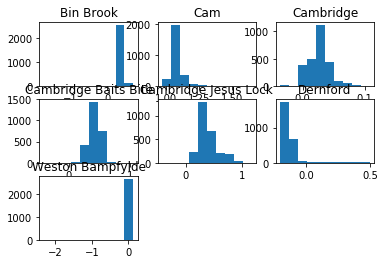

In [29]:
norm_value = (flood['value'] - flood['low']) / (flood['high'] - flood['low'])
labels = np.unique(flood['label'])

fig = plt.figure()
for i,lbl in enumerate(labels):
    ax = fig.add_subplot(3, 3, i+1)        # numrows=3, numcols=3, new subplot in the (i+1)th position
    x = norm_value[flood['label'] == lbl]
    x = x[~np.isnan(x)]                    # remove NaN values since ax.hist doesn't work with them
    ax.hist(x)
    ax.set_title(lbl)

To make the plot look lovely, we need some plot-tweaking.

* `fig.add_subplot` lets us [specify axes to be shared](https://matplotlib.org/users/recipes.html). The code below makes all the subplots share the same x axis as the top left subplot.

* Since all the subplots share the same x axis, but the data for each plot is different, `ax.hist` will choose different bins for each subplot. It looks better to force them all to use the same bins.

* Use `plt.get_cmap(name, n)` to get a colour map with `n` values, where `name` is one of the [standard colour-map names](https://matplotlib.org/users/colormaps.html).

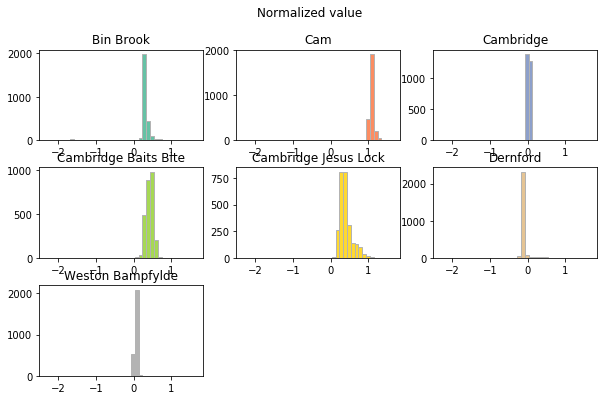

In [30]:
labels = np.unique(flood['label'])
norm_value = (flood['value'] - flood['low']) / (flood['high'] - flood['low'])
bins = np.linspace(min(norm_value), max(norm_value), 40)

with matplotlib.rc_context({'figure.figsize': [10,6], 'figure.subplot.hspace': 0.3}):
    colors = plt.get_cmap('Set2', len(labels))
    fig = plt.figure()
    ax0 = None
    for i,lbl in enumerate(labels):
        if ax0 is None:
            ax = fig.add_subplot(3, 3, i+1)
            ax0 = ax
        else:
            ax = fig.add_subplot(3, 3, i+1, sharex=ax0)
        x = norm_value[flood['label'] == lbl]
        x = x[~np.isnan(x)]
        ax.hist(x, bins=bins, facecolor=colors(i), edgecolor='0.7')
        ax.set_title(lbl)
    fig.suptitle('Normalized value')

<div style="background-color:wheat"><strong>Exercise.</strong>
Which values of <em>i</em> correspond to the three bottom-most panels?
Use <code style="background-color:wheat">ax.get_xaxis().set_visible(False)</code> to turn off the ticks on all the other panels, so the panel labels can be read cleanly.
<em>Solution: if <code style="background-color:wheat">i + 3 &geq; len(labels)</code> then panel <em>i</em> is bottom-most.</em>
</div>

## 3.8 Cross tabulation

Surely I want a table output! https://gist.github.com/alexland/d6d64d3f634895b9dc8e

In [39]:
x = np.rec.fromarrays([flood['label'], flood['river']])
vs, idx = np.unique(x, return_inverse=True)
summary(idx.astype(str))

[('0', 2665), ('1', 2665), ('6', 2657), ('3', 2653), ('4', 2653)]

In [43]:
pandas.DataFrame(flood).pivot_table(values='town', index=['town','river'], aggfunc=len)

ValueError: Grouper for 'town' not 1-dimensional

In [41]:
pandas.pivot_table(pandas.DataFrame(flood), values=None, index=['town','river'])

high        lat       lng       low  \
town             river                                                
Cam              River Cam  0.782000  51.699985 -2.360238  0.578000   
Cambridge        Bin Brook  0.368000  52.197227  0.087527  0.057000   
                 River Cam  0.994615  51.971998 -1.118798  0.389374   
Great Shelford   River Cam  0.395000  52.134462  0.141784  0.127000   
Milton           River Cam  0.294000  52.236542  0.176925  0.218000   
Weston Bampfylde River Cam  0.600000  51.023159 -2.565568  0.026000   

                             measure_id  period     value  
town             river                                     
Cam              River Cam  1636.000000   900.0  0.798811  
Cambridge        Bin Brook  1792.000000   900.0  0.150815  
                 River Cam  1783.376935   900.0  0.424387  
Great Shelford   River Cam  1724.000000   900.0  0.097247  
Milton           River Cam  1455.000000   900.0  0.249376  
Weston Bampfylde River Cam   919.000000   900.0  0.054655

In [7]:
def crosstab(df, cols, countlabel='n'):
    x = np.rec.fromarrays([df[col] for col in cols], names=cols)
    vs, ns = np.unique(x, return_counts=True)
    x = OrderedDict((k,vs[k]) for k in vs.dtype.names)
    if countlabel is not None:
        x[countlabel] = ns
    return x

In [8]:
pandas.DataFrame(crosstab(flood, ['label','measure_id']))

,label,measure_id,n
0,Bin Brook,1792,2665
1,Cam,1636,2665
2,Cambridge,1865,2645
3,Cambridge Baits Bite,1455,2653
4,Cambridge Jesus Lock,1702,2653
5,Dernford,1724,2617
6,Weston Bampfylde,919,2657


In [27]:
# Question. Is there one label/measure_id per town:river?
x = crosstab(flood, ['town','river','measure_id'])
y = crosstab(x, ['town','river'], countlabel='num_measures')
i = pandas.MultiIndex.from_arrays([y['town'], y['river']])
z1 = pandas.Series(y['num_measures'], index=i)
z2 = z1.unstack(1, fill_value=0)
z1

Cam               River Cam    1
Cambridge         Bin Brook    1
                  River Cam    2
Great Shelford    River Cam    1
Milton            River Cam    1
Weston Bampfylde  River Cam    1
dtype: int64

In [31]:
z1[:,'River Cam']

Cam                 1
Cambridge           2
Great Shelford      1
Milton              1
Weston Bampfylde    1
dtype: int64

In [5]:
towns,itowns = np.unique(flood['town'], return_inverse=True)
rivers,irivers = np.unique(flood['river'], return_inverse=True)
idx,ns = np.unique(np.vstack([itowns,irivers]).T, axis=0, return_counts=True)
x = np.zeros([len(towns), len(rivers)])
x[tuple(idx.T)] = ns
x

array([[    0.,  2665.],
       [ 2665.,  5298.],
       [    0.,  2617.],
       [    0.,  2653.],
       [    0.,  2657.]])

In [ ]:
pandas.DataFrame(flood).pivot_table()

## 3.9 Joining dataframes

## 3.10 Pivoting between wide and long dataframes